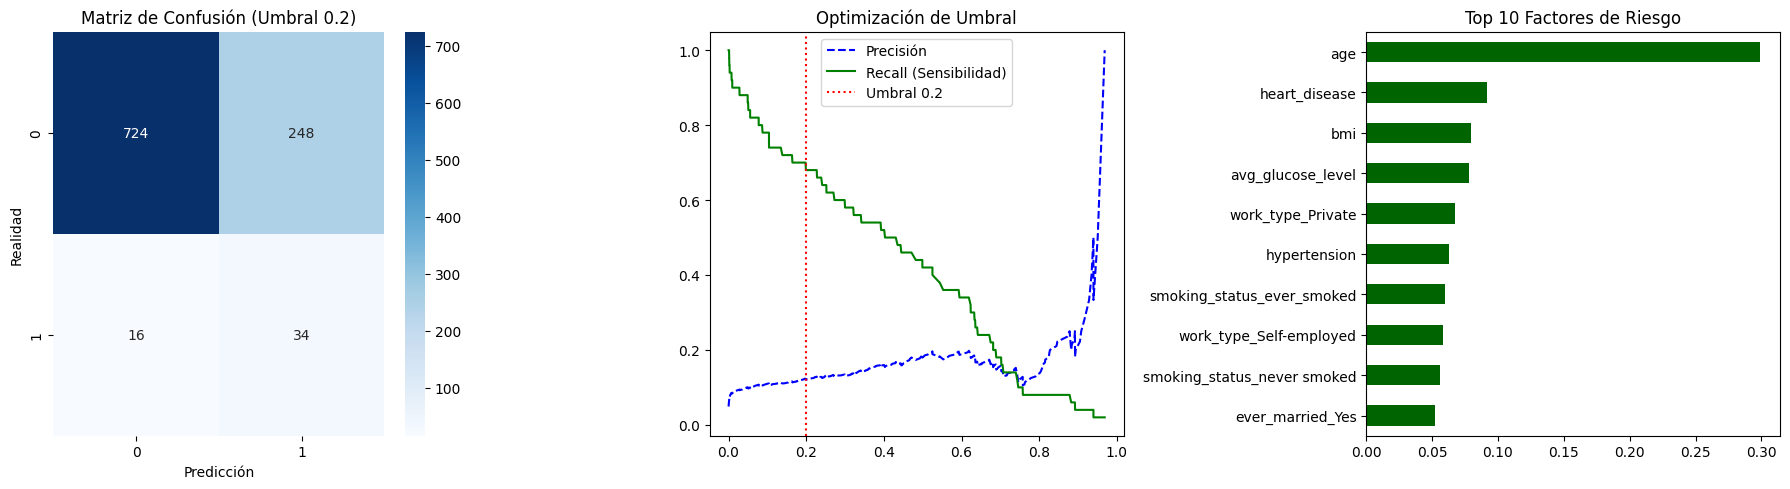


--- REPORTE FINAL ---
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       972
           1       0.12      0.68      0.20        50

    accuracy                           0.74      1022
   macro avg       0.55      0.71      0.53      1022
weighted avg       0.94      0.74      0.81      1022



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score

# 1. CARGA DE DATOS
# Cargamos el dataset original (el que tiene las columnas de texto y números sin procesar)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')

# 2. INGENIERÍA DE CARACTERÍSTICAS (Feature Engineering)
def engineer_features(df_input):
    df_new = df_input.copy()
    
    # Categorización de Edad
    df_new['age_group'] = pd.cut(df_new['age'], 
                                 bins=[0, 18, 45, 60, 100], 
                                 labels=['Child', 'Adult', 'Senior', 'Critical_Risk'])
    
    # Categorización de BMI (OMS)
    df_new['bmi_cat'] = pd.cut(df_new['bmi'], 
                               bins=[0, 18.5, 24.9, 29.9, 100], 
                               labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # Categorización de Glucosa
    df_new['glucose_cat'] = pd.cut(df_new['avg_glucose_level'], 
                                   bins=[0, 100, 125, 300], 
                                   labels=['Normal', 'Prediabetes', 'Diabetes'])
    
    # Convertir a variables numéricas (Dummies)
    # Incluimos las nuevas categorías y las originales que sean texto
    cols_to_dummy = ['age_group', 'bmi_cat', 'glucose_cat', 'gender', 
                     'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    
    df_new = pd.get_dummies(df_new, columns=cols_to_dummy, drop_first=True)
    return df_new

df_final = engineer_features(df)

# 3. PREPARACIÓN PARA EL MODELO
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. ENTRENAMIENTO (Modelo Scale Pos Weight Optimizado)
model = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=19.4, # Balanceo de clases
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# 5. APLICACIÓN DE UMBRAL 0.2
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_02 = (y_probs >= 0.2).astype(int)

# 6. EVALUACIÓN Y GRÁFICAS
plt.figure(figsize=(18, 5))

# Matriz de Confusión
plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_02), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión (Umbral 0.2)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

# Curva Precision-Recall
plt.subplot(1, 3, 2)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precisión')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Sensibilidad)')
plt.axvline(x=0.2, color='red', linestyle=':', label='Umbral 0.2')
plt.title('Optimización de Umbral')
plt.legend()

# Importancia de Variables
plt.subplot(1, 3, 3)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='darkgreen')
plt.title('Top 10 Factores de Riesgo')

plt.tight_layout()
plt.show()

print("\n--- REPORTE FINAL ---")
print(classification_report(y_test, y_pred_02))

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_12652\2477408318.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=feature_importance_df.head(10), palette='viridis')


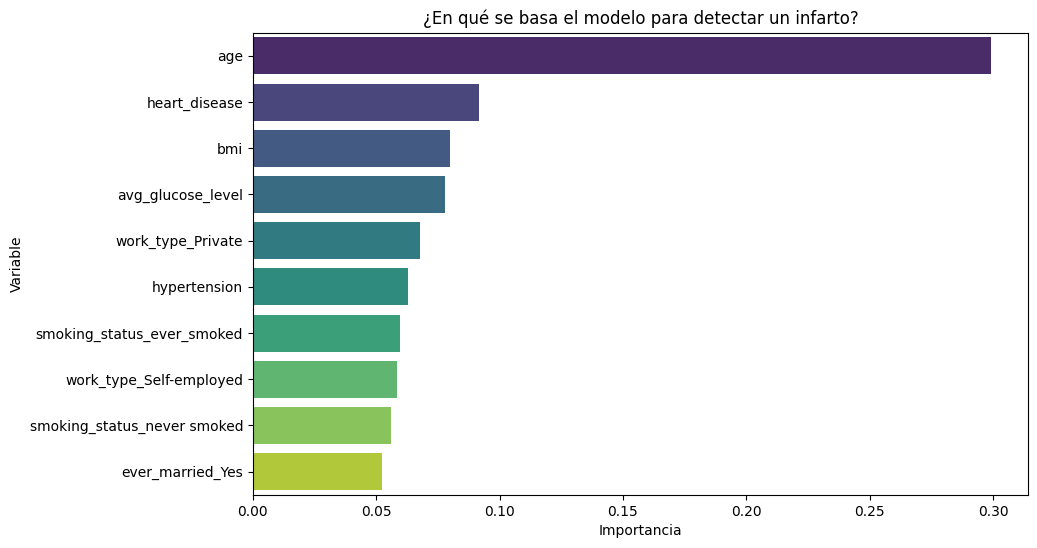

In [2]:
# Obtener la importancia de las variables
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=feature_importance_df.head(10), palette='viridis')
plt.title('¿En qué se basa el modelo para detectar un infarto?')
plt.show()

El umbral sugerido para maximizar Recall al 80% es: 0.0863


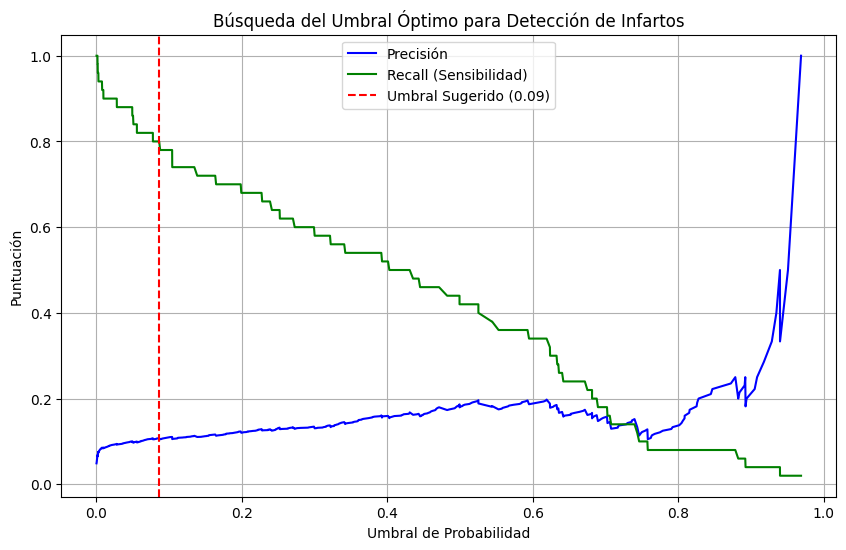

In [3]:
from sklearn.metrics import precision_recall_curve

# 1. Calcular precisión, recall y umbrales
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 2. Crear un DataFrame para buscar el umbral ideal
# Queremos un Recall alto (ej. > 0.80) pero viendo qué pasa con la precisión
df_recall = pd.DataFrame({
    'Umbral': thresholds,
    'Precision': precisions[:-1],
    'Recall': recalls[:-1]
})

# 3. Buscar el umbral donde el Recall es máximo pero la precisión no es 0
# Por ejemplo, busquemos el umbral que nos da el Recall más cercano a 0.85
umbral_ideal = df_recall[df_recall['Recall'] >= 0.80]['Umbral'].max()

print(f"El umbral sugerido para maximizar Recall al 80% es: {umbral_ideal:.4f}")

# 4. Graficar la búsqueda del punto de equilibrio
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recalls[:-1], label="Recall (Sensibilidad)", color='green')
plt.axvline(x=umbral_ideal, color='red', linestyle='--', label=f'Umbral Sugerido ({umbral_ideal:.2f})')
plt.title('Búsqueda del Umbral Óptimo para Detección de Infartos')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('Puntuación')
plt.legend()
plt.grid(True)
plt.show()